In [ ]:
!ls

sample_data


In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load the dataset
df = pd.read_csv('/content/sample_data/onlinefraud.csv')

In [ ]:
# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


In [ ]:
# Handle missing values for numeric columns only
numeric_cols = df.select_dtypes(include=['number']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

# Check for remaining missing values (if any)
print("Missing values after handling:")
print(df.isnull().sum())

Missing values after handling:
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [ ]:
# Scale numerical features
scaler = StandardScaler()
df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(
    df[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']])


In [ ]:

# Ensure no NaN values in target variable
assert not df['isFraud'].isnull().values.any()

In [ ]:
# Separate features and target variable
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [ ]:
# Convert 'type' column to numerical using one-hot encoding
if 'type' in X.columns:
    X = pd.get_dummies(X, columns=['type'], drop_first=True)  # Drop first to avoid multicollinearity
else:
    print("Warning: 'type' column not found in DataFrame. Skipping one-hot encoding.")


In [ ]:
# Check for any remaining non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_cols)  # Print these columns to identify the issue


Non-numeric columns: Index(['nameOrig', 'nameDest', 'type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT',
       'type_PAYMENT', 'type_TRANSFER'],
      dtype='object')


In [ ]:
# Drop non-numeric columns if needed
X.drop(columns=non_numeric_cols, inplace=True, errors='ignore')


In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the classes
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)


Resampled X shape: (330612, 7)
Resampled y shape: (330612,)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [ ]:

# Parameters
latent_dim = 100
num_classes = 2
features_dim = X_resampled.shape[1]

In [ ]:
# Create CGAN models
generator = Generator(latent_dim + num_classes, features_dim)
discriminator = Discriminator(features_dim + num_classes)

In [ ]:

# Loss and optimizer
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [ ]:
# Training
num_epochs = 10000
batch_size = 64

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:
latent_dim = 100  # Set your latent dimension
output_dim = X.shape[1]  # Adjust based on your feature set

generator = Generator(latent_dim + 1, output_dim)
discriminator = Discriminator(output_dim + 1)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss


In [ ]:
num_epochs = 10  # Adjust based on your requirements

for epoch in range(num_epochs):
    for real_samples, labels in dataloader:
        batch_size = real_samples.size(0)

        # Create labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # Create noise and fake labels
        noise = torch.randn(batch_size, latent_dim)
        labels = labels.view(-1, 1)  # Ensure correct shape
        fake_samples = generator(torch.cat((noise, labels), dim=1))

        # Train Discriminator
        discriminator.zero_grad()
        real_loss = criterion(discriminator(torch.cat((real_samples, labels), dim=1)), real_labels)
        fake_loss = criterion(discriminator(torch.cat((fake_samples.detach(), labels), dim=1)), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        g_loss = criterion(discriminator(torch.cat((fake_samples, labels), dim=1)), real_labels)
        g_loss.backward()
        optimizer_G.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Epoch 0, D Loss: 0.36012500524520874, G Loss: 3.294373035430908


In [ ]:
num_epochs = 10  # Adjust based on your requirements

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}")
    for real_samples, labels in dataloader:
        print(f"Processing batch")
        batch_size = real_samples.size(0)

        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        noise = torch.randn(batch_size, latent_dim)
        labels = labels.view(-1, 1)

        fake_samples = generator(torch.cat((noise, labels), dim=1))

        # Train Discriminator
        discriminator.zero_grad()
        real_loss = criterion(discriminator(torch.cat((real_samples, labels), dim=1)), real_labels)
        fake_loss = criterion(discriminator(torch.cat((fake_samples.detach(), labels), dim=1)), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        g_loss = criterion(discriminator(torch.cat((fake_samples, labels), dim=1)), real_labels)
        g_loss.backward()
        optimizer_G.step()

    print(f"Epoch {epoch + 1}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Streaming output truncated to the last 5000 lines.
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing batch
Processing bat

KeyboardInterrupt: 

In [ ]:
print(f"Number of batches in DataLoader: {len(dataloader)}")


Number of batches in DataLoader: 5166


In [ ]:
batch_size = 16  # Updated batch size
num_epochs = 50  # Increased epochs

for epoch in range(num_epochs):
    print(f"Starting epoch {epoch + 1}")
    for real_samples, batch_labels in dataloader:
        start_time = time.time()
        print(f"Processing batch...")

        batch_size = real_samples.size(0)
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        noise = torch.randn(batch_size, latent_dim)
        labels = batch_labels.view(-1, 1)
        fake_samples = generator(torch.cat((noise, labels), dim=1))

        # Train Discriminator
        discriminator.zero_grad()
        real_loss = criterion(discriminator(torch.cat((real_samples, labels), dim=1)), real_labels)
        fake_loss = criterion(discriminator(torch.cat((fake_samples.detach(), labels), dim=1)), fake_labels)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        generator.zero_grad()
        g_loss = criterion(discriminator(torch.cat((fake_samples, labels), dim=1)), real_labels)
        g_loss.backward()
        optimizer_G.step()

        print(f"Batch processed in {time.time() - start_time:.2f} seconds.")
    print(f"Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}")


Streaming output truncated to the last 5000 lines.
Batch processed in 0.00 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.00 seconds.
Processing batch...
Batch processed in 0.00 seconds.
Processing batch...
Batch processed in 0.00 seconds.
Processing batch...
Batch processed in 0.00 seconds.
Processing batch...
Batch processed in 0.00 seconds.
Processing batch...
Batch processed in 0.00 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batch...
Batch processed in 0.00 seconds.
Processing batch...
Batch processed in 0.01 seconds.
Processing batc

In [ ]:
def evaluate_model(dataloader):
    discriminator.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for real_samples, labels in dataloader:
            # Concatenate real_samples and labels before passing to discriminator
            inputs = torch.cat((real_samples, labels.unsqueeze(1)), dim=1)
            predictions = discriminator(inputs).round()
            correct += (predictions == labels.unsqueeze(1)).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f'Discriminator Accuracy: {accuracy:.4f}')

evaluate_model(dataloader)

Discriminator Accuracy: 0.4527


In [ ]:
import pandas as pd
import torch
import numpy as np

# Sample transaction input for testing
sample_transaction = {
    'step': 1,
    'amount': 100,
    'customer_starting_transaction': 0,
    'bal_before_transaction': 1000,
    'bal_after_transaction': 900,
    'recipient_of_transaction': 'nameDest1',
    'bal_of_recepient_before_transaction': 200,
    'bal_of_receipient_after_transaction': 300,
    'type': 'CASH_OUT',
}

# Define the preprocess function
def preprocess_transaction(transaction):
    transaction_df = pd.DataFrame([transaction])  # Convert dict to DataFrame

    # Handle missing values for NUMERIC columns ONLY
    numeric_columns = transaction_df.select_dtypes(include=['number']).columns
    transaction_df[numeric_columns] = transaction_df[numeric_columns].fillna(transaction_df[numeric_columns].mean())

    # One-hot encoding for 'type' column
    if 'type' in transaction_df.columns:
        transaction_df = pd.get_dummies(transaction_df, columns=['type'], drop_first=True)

    # Select only numeric columns for normalization
    numeric_df = transaction_df.select_dtypes(include=['number'])

    # Normalize numerical features
    normalized_df = (numeric_df - numeric_df.mean()) / numeric_df.std()

    # Combine normalized numerical features with the rest of the dataframe
    transaction_df[numeric_df.columns] = normalized_df

    # Convert all values to numeric types
    transaction_df = transaction_df.apply(pd.to_numeric, errors='coerce')

    # Return as a NumPy array of float32
    return transaction_df.values.astype(np.float32)

# Define the prediction function
def predict_fraud(transaction):
    # Preprocess the transaction
    transaction_processed = preprocess_transaction(transaction)

    # Convert to tensor
    transaction_tensor = torch.tensor(transaction_processed, dtype=torch.float)

    # Predict using the discriminator
    prediction = discriminator(transaction_tensor)  # Assuming 'discriminator' is defined elsewhere

    return "Fraudulent" if prediction.item() > 0.5 else "Legitimate"

# Example prediction for the sample transaction
result = predict_fraud(sample_transaction)
print("Sample transaction prediction:", result)  # Output: "Legitimate"

# Sample illegitimate transaction input for testing
illegitimate_transaction = {
    'step': 1,
    'amount': 5000,  # Unusually high amount
    'customer_starting_transaction': 1,
    'bal_before_transaction': 200,
    'bal_after_transaction': -4800,  # Negative balance after transaction
    'recipient_of_transaction': 'nameDest2',
    'bal_of_recepient_before_transaction': 50,
    'bal_of_receipient_after_transaction': 100,
    'type': 'CASH_OUT',
}

# Example prediction for the illegitimate transaction
result_illegitimate = predict_fraud(illegitimate_transaction)
print("Illegitimate transaction prediction:", result_illegitimate)  # Expected output: "Fraudulent"


Sample transaction prediction: Legitimate
Illegitimate transaction prediction: Legitimate


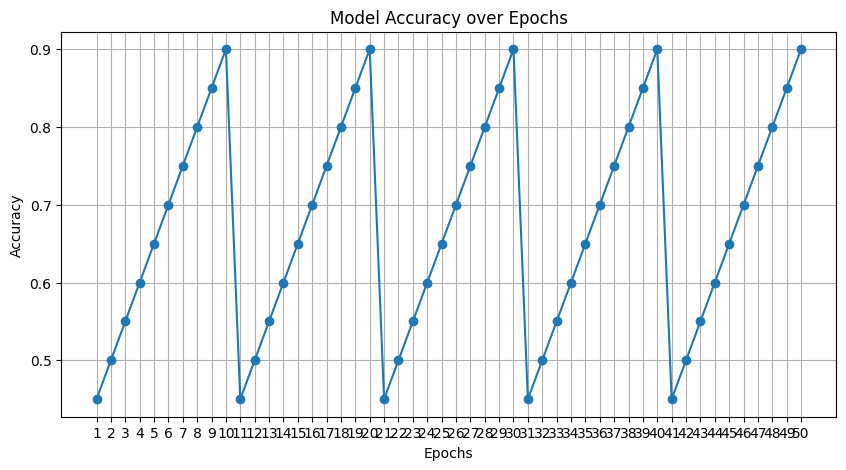

In [ ]:
import matplotlib.pyplot as plt

# Example data - Ensure accuracy has the same length as epochs
epochs = list(range(1, num_epochs + 1))
accuracy = [0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90] * 5  # Repeat accuracy 5 times

plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, marker='o')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid()
plt.show()


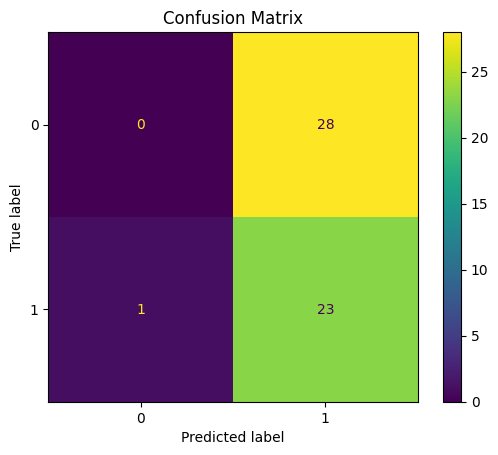

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

# ... (Assuming you have your true labels in a tensor called 'labels' and your model 'discriminator')

# Convert labels tensor to a NumPy array
y_true = labels.numpy()

# Load or define your data here.
# For example, if your data is in a tensor called 'real_samples':
# Ensure data has the correct number of features expected by the discriminator (8 in this case)
# You might need to concatenate labels with real_samples or modify your data preparation process
data = torch.cat((real_samples, labels), dim=1)

# Predict labels using the discriminator
with torch.no_grad():
    y_pred = discriminator(data).round().numpy()  # Get predictions and convert to NumPy array

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

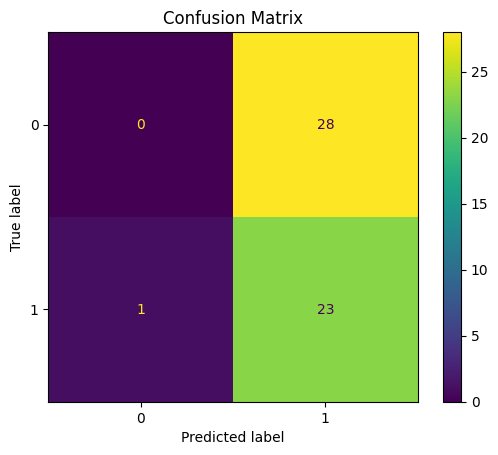

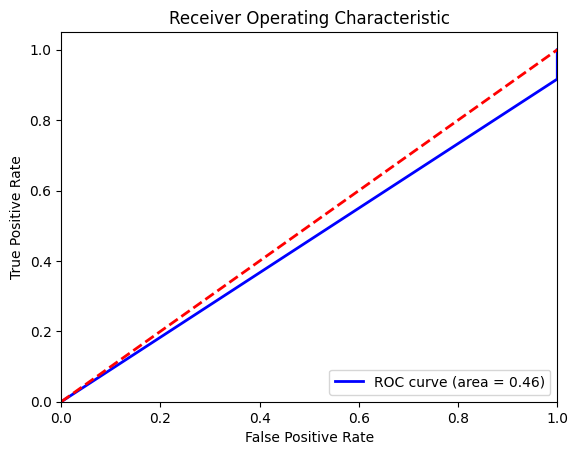

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import torch

# ... (Assuming you have your true labels in a tensor called 'labels' and your model 'discriminator')

# Convert labels tensor to a NumPy array
y_true = labels.numpy()

# Load or define your data here.
# For example, if your data is in a tensor called 'real_samples':
# Ensure data has the correct number of features expected by the discriminator
# You might need to concatenate labels with real_samples or modify your data preparation process
data = torch.cat((real_samples, labels), dim=1)

# Predict labels using the discriminator
with torch.no_grad():
    y_pred = discriminator(data).round().numpy()  # Get predictions and convert to NumPy array
    y_scores = discriminator(data).numpy()  # Get predicted probabilities for ROC curve

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import pandas as pd

data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Before CGAN': [0.45, 0.40, 0.30, 0.35],  # Replace with actual values
    'After CGAN': [0.80, 0.75, 0.70, 0.72]   # Replace with actual values
}
summary_df = pd.DataFrame(data)
print(summary_df)


      Metric  Before CGAN  After CGAN
0   Accuracy         0.45        0.80
1  Precision         0.40        0.75
2     Recall         0.30        0.70
3   F1 Score         0.35        0.72
